In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from itertools import combinations

In [3]:
import networkx as nx

In [4]:
from os.path import join

In [5]:
import geopandas as gpd

In [6]:
df = pd.read_csv("../data/crime.csv", parse_dates=True, encoding="utf-8", 
                 index_col=["object_id", "date"])
level_values = df.index.get_level_values

In [7]:
df_agg = df.groupby([level_values(0)] + [pd.Grouper(freq='W', closed='left', level=-1)]).agg(
    events =  ("cassualties", "count"),
    cassualties = ("cassualties", "sum"),
    lat = ("lat", "first"),
    lon = ("lon", "first"),
    postal_code = ("postal_code", "first"),
    mun_name = ("mun_name", "first"),
    neighborhood_name = ("neighborhood_name", "first"),
    neighborhood_type = ("neighborhood_type", "first")
)

In [8]:
df_agg.sort_index(level=['object_id','date'], inplace=True, ascending=[True, True])

In [9]:
df_agg = df_agg.loc[df_agg.index.get_level_values(0) != 0 ].copy()   

In [10]:
df_agg.head()

events  cassualties        lat         lon  postal_code  \
object_id date                                                                  
33597     2013-04-28       1          1.0  25.762639 -100.207071      66600.0   
33600     2011-01-30       1          1.0  25.781562 -100.187597      66600.0   
          2011-05-08       1          5.0  25.781562 -100.187597      66600.0   
          2011-09-25       1          1.0  25.781562 -100.187597      66600.0   
          2012-01-29       1          1.0  25.781562 -100.187597      66600.0   

                     mun_name          neighborhood_name neighborhood_type  
object_id date                                                              
33597     2013-04-28  APODACA  PARQUE INDUSTRIAL QUADRUM           COLONIA  
33600     2011-01-30  APODACA             APODACA CENTRO           COLONIA  
          2011-05-08  APODACA             APODACA CENTRO           COLONIA  
          2011-09-25  APODACA             APODACA CENTRO           COLONIA  
          2012-01-29  APODACA             APODACA CENTRO           COLONIA

In [11]:
years = pd.date_range("2010-12-31", max(level_values(1)), freq='Y')

In [64]:
def get_crime_inter_per_week(df, start, end):
    ### function to get networks with crime neighborhoods linked by a start and end time frame. 
    ### df is a multi index data frame. Index 0: Locations. Index 1: Time
    ### map_df has the neighborhood info
    ### G is the network from all adjacent neighborhoods
    idx = pd.IndexSlice
    ### solo las entradas en esa seccion de tiempo
    df_filter = df.loc[idx[:, start:end], :]
    inter = []
    weekset = set(df_filter.index.get_level_values(1))
    for week in weekset:
        week_obj = df_filter[df_filter.index.get_level_values(1) == week].index.get_level_values(0).tolist()
        week_obj_comb = list(combinations(week_obj,2))
        week_obj_df = pd.DataFrame(np.array([[t[0], t[1]] for t in week_obj_comb]))
        inter.append(week_obj_df)
    inter = pd.concat(inter)
    inter.columns = ["source", "target"]
    inter = inter.groupby(["source", "target"]).size().reset_index()
    inter.columns = ["source", "target", "count"]
    inter.sort_values("count",inplace=True, ascending=False )
    return(inter)

In [65]:
networks  = []
for i in range(len(years)-1):
    g = get_crime_inter_per_week(df_agg, years[i], years[i+1])
    networks.append(g)
g = get_crime_inter_per_week(df_agg, years[-1], pd.to_datetime("2018-12-31"))
networks.append(g)

In [66]:
networks[1]

source   target  count
618   33901.0  34955.0     12
1982  34955.0  35376.0     10
657   33901.0  35376.0      8
610   33901.0  34713.0      6
1645  34713.0  34955.0      6
...       ...      ...    ...
1084  34117.0  34955.0      1
1085  34117.0  34979.0      1
1086  34117.0  35264.0      1
1087  34117.0  35913.0      1
3142  36421.0  36477.0      1

[3143 rows x 3 columns]

### Display the network

In [67]:
municipios = pd.read_csv("../data/municipios.txt", encoding = "utf-8", header = None, names = ["name"])
municipios = municipios.name.tolist()

In [68]:
map_df = pd.read_csv("../data/map_df_all.csv")

In [69]:
nodeData = map_df[["object_id", "mun_name", "neighborhood_name", "neighborhood_type", 
                   "area", "x_centroid", "y_centroid", "with_event"]].set_index("object_id").to_dict('index')

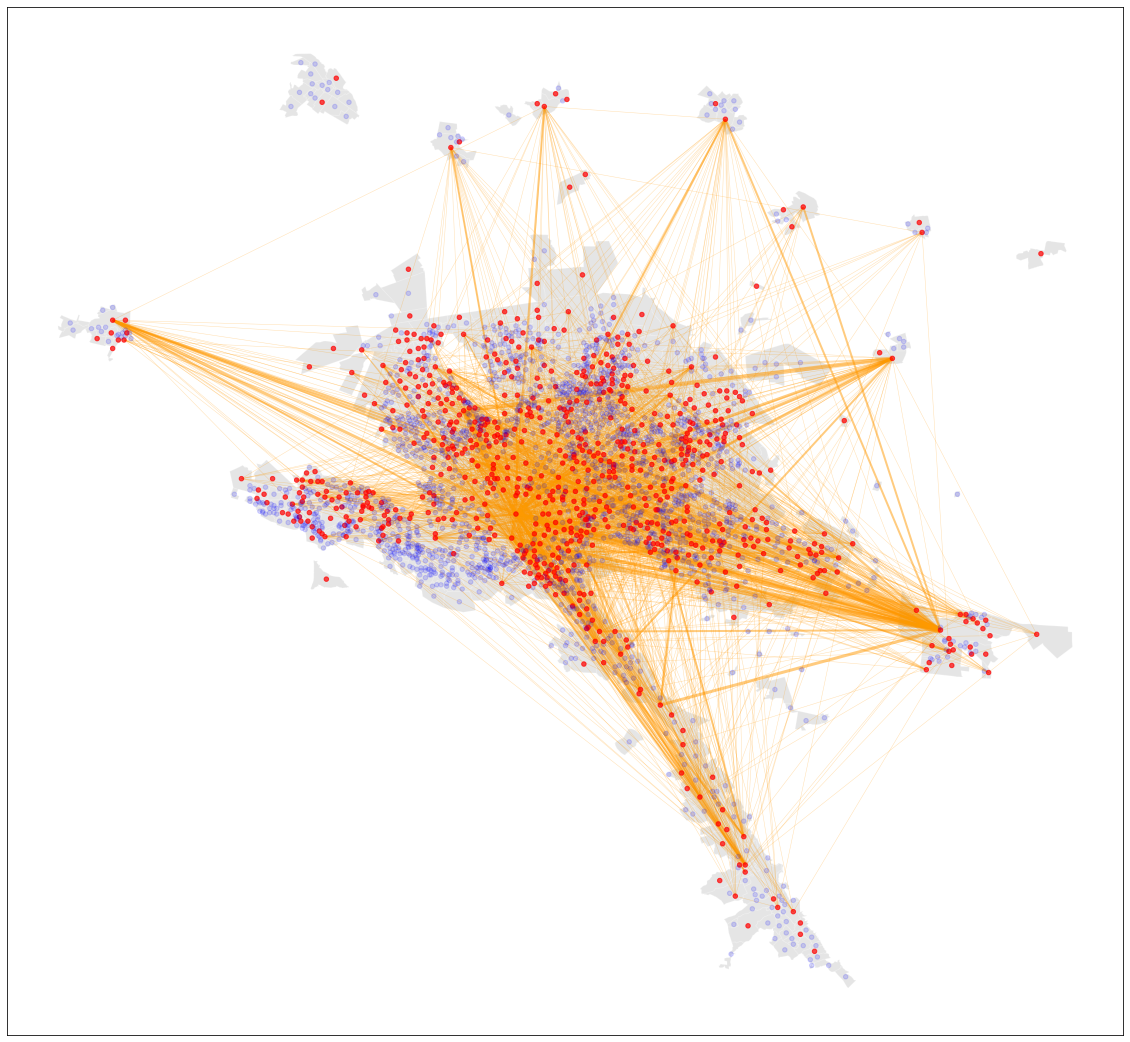

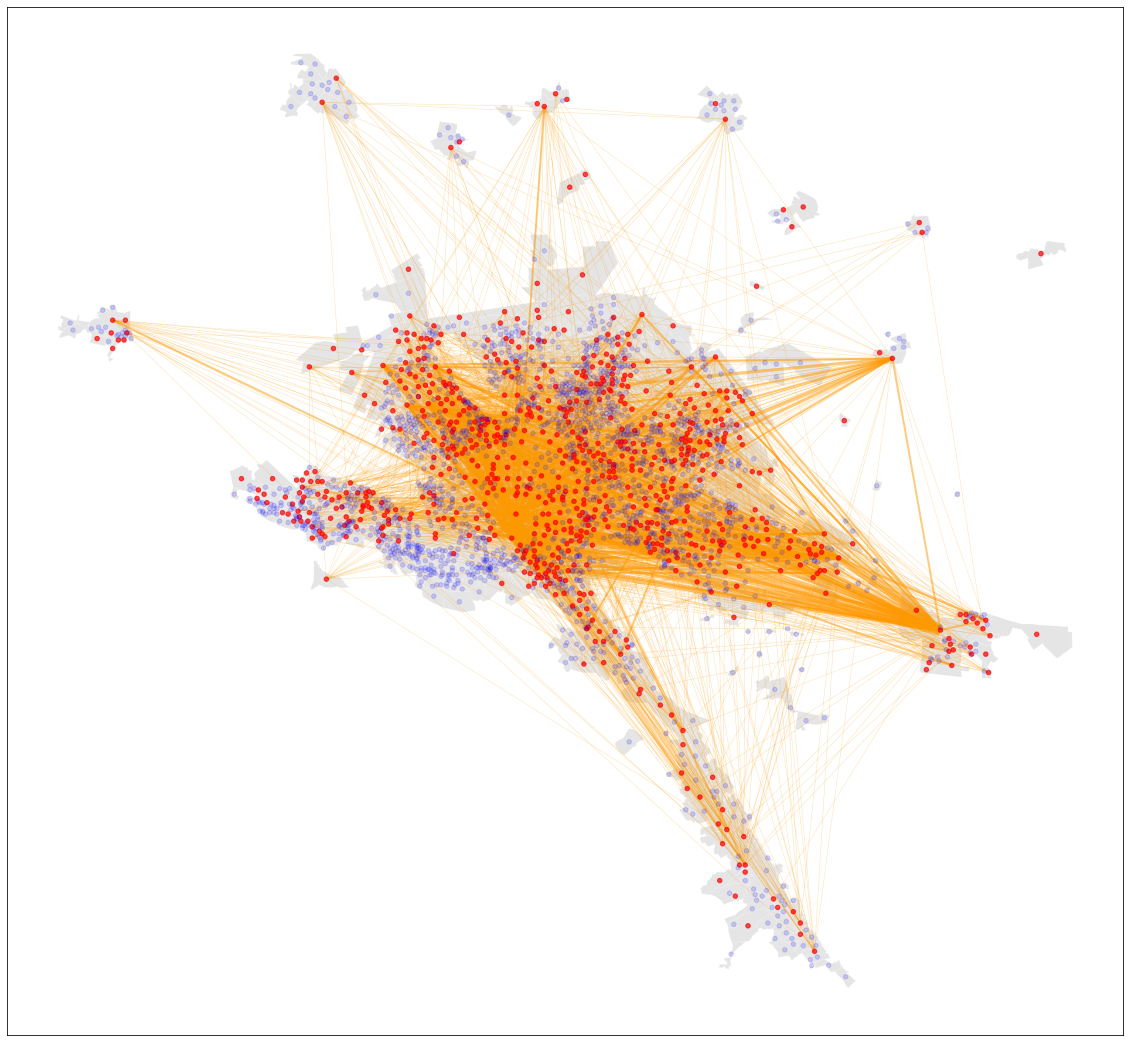

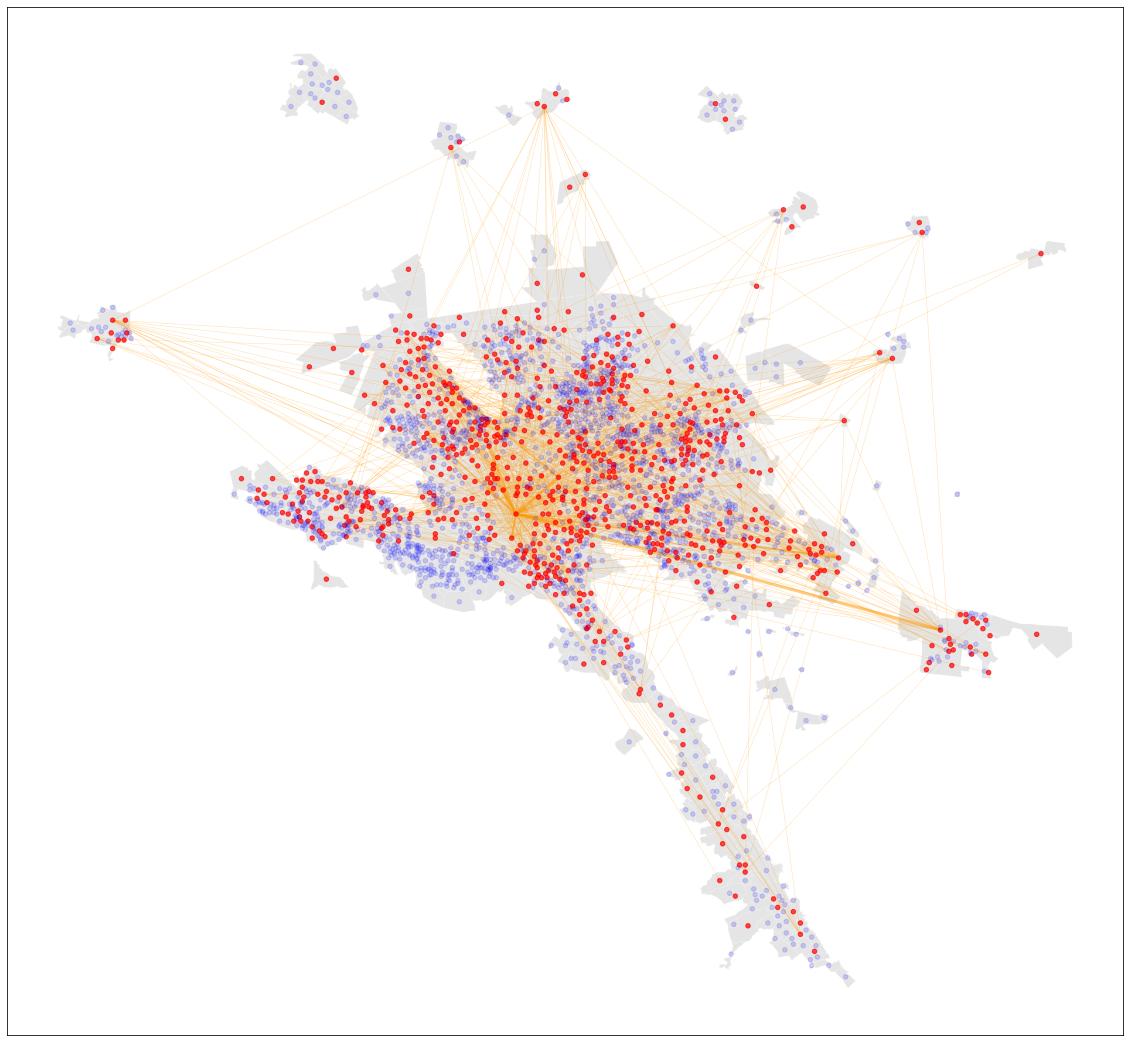

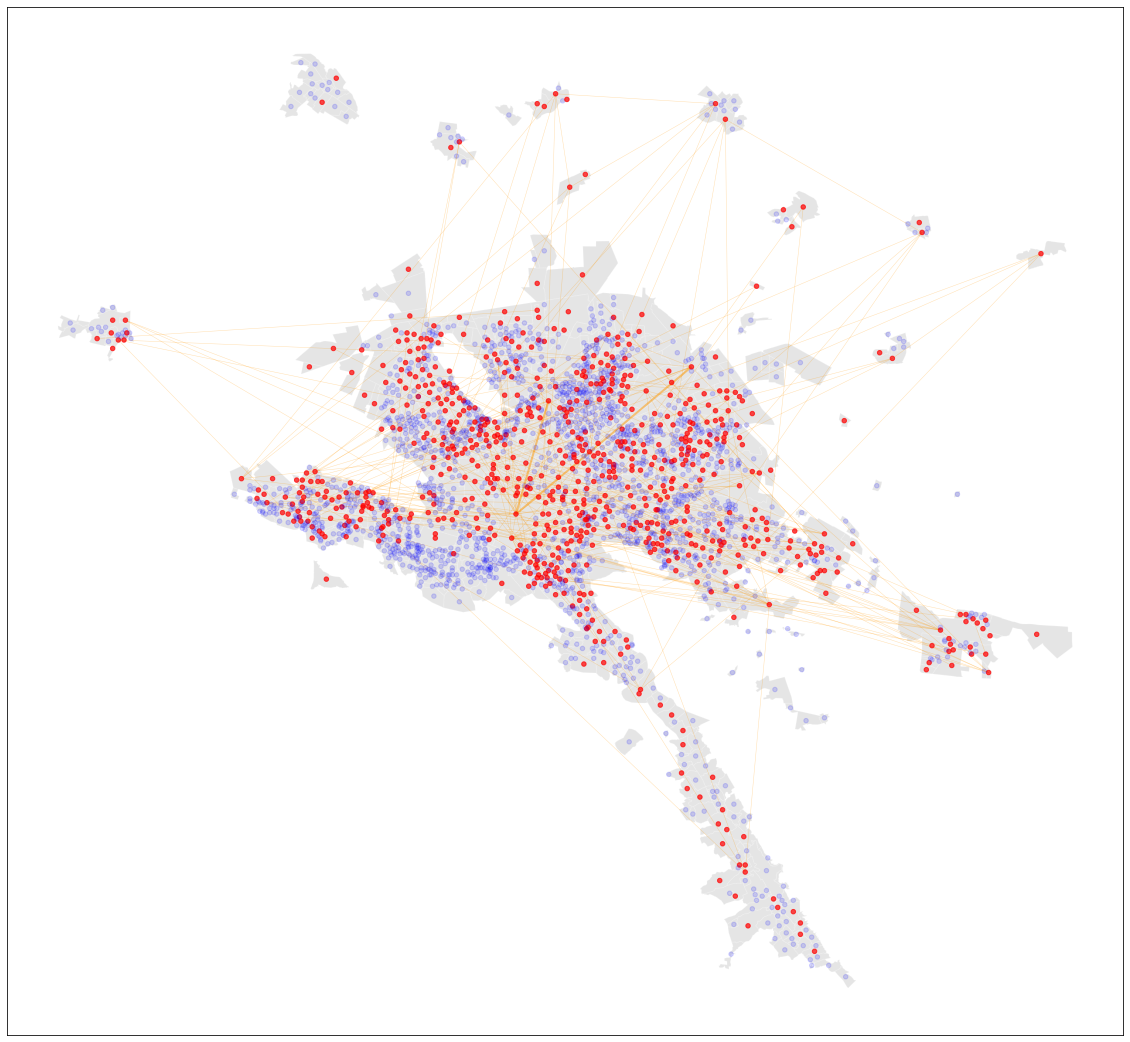

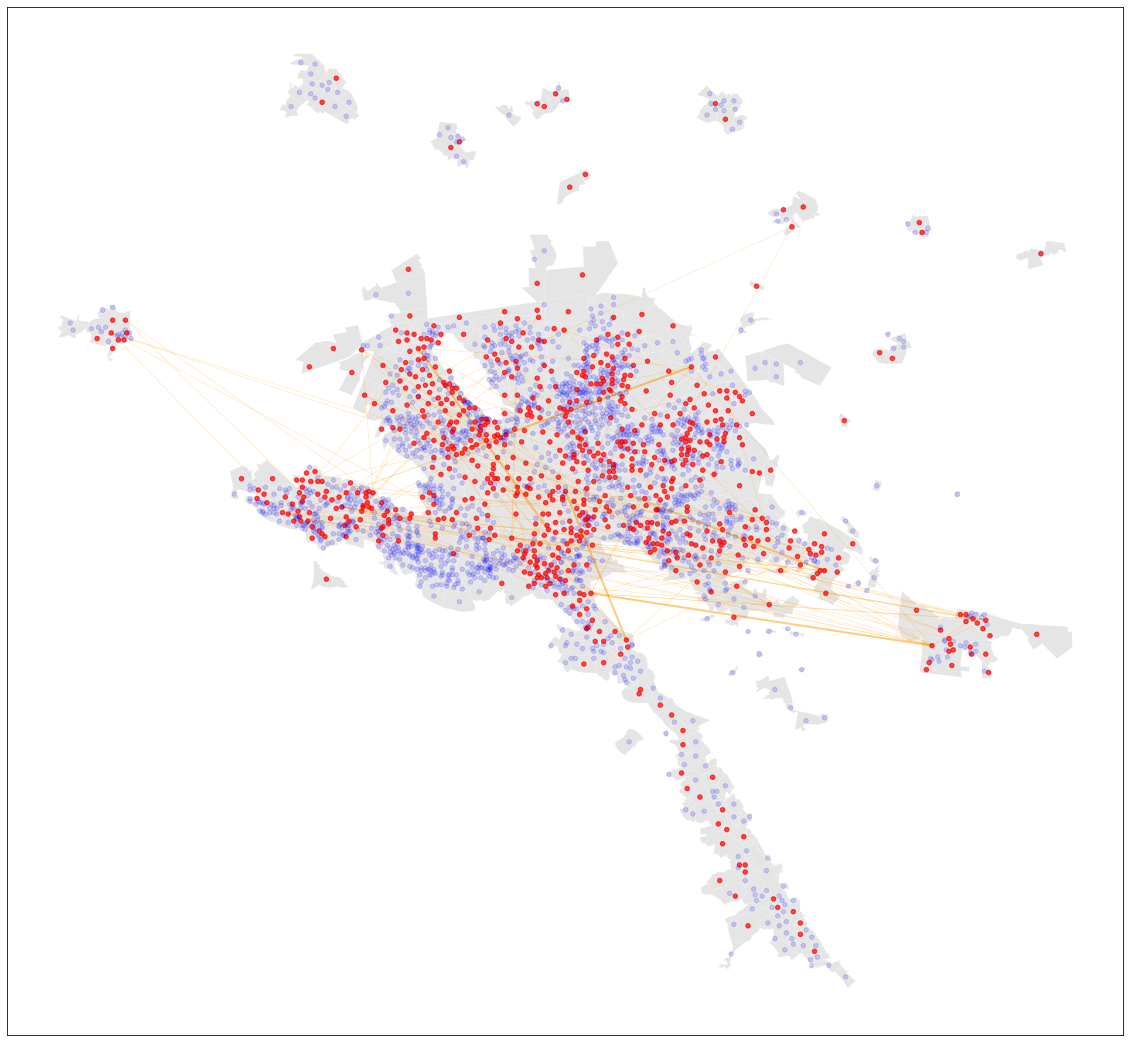

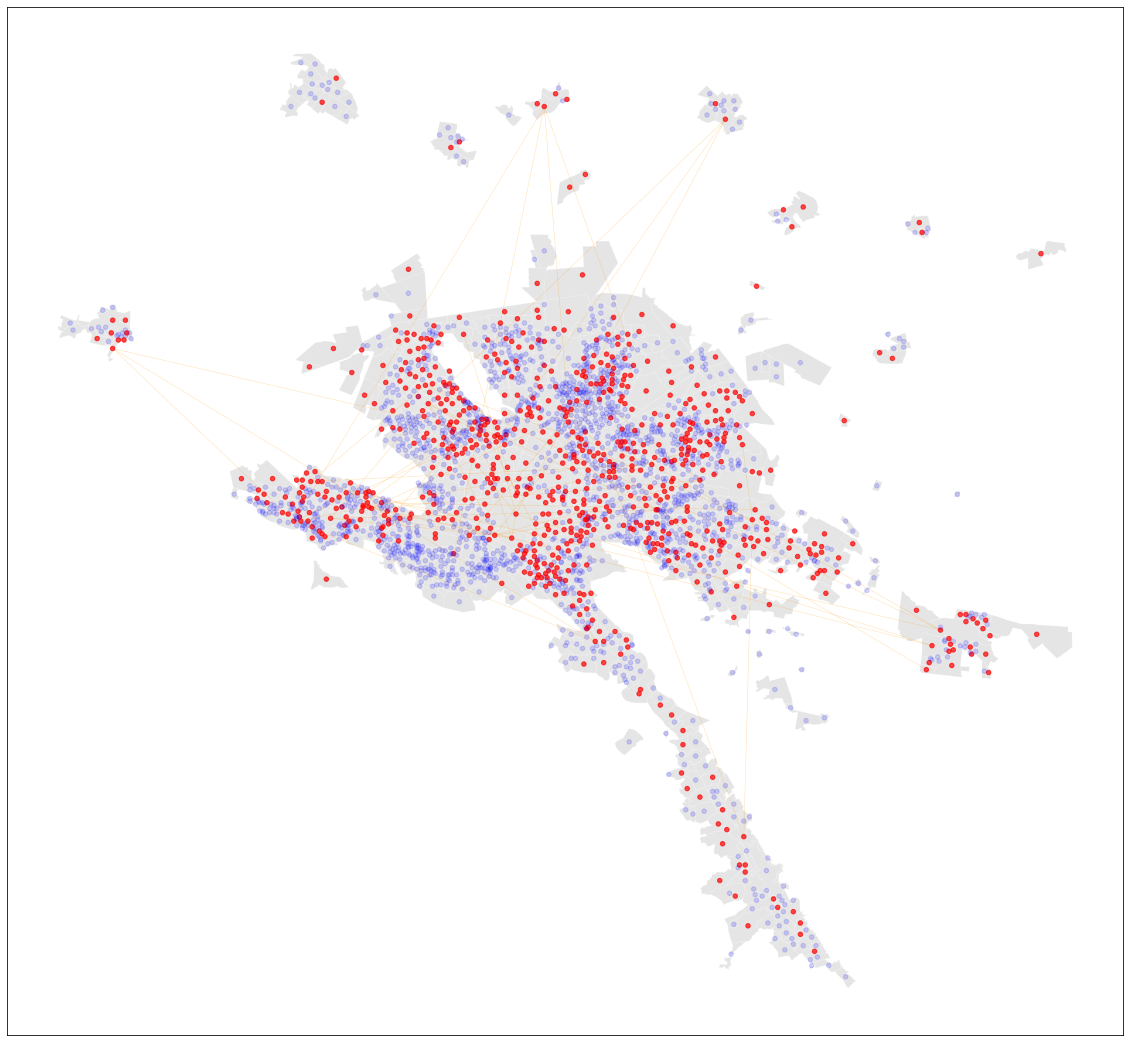

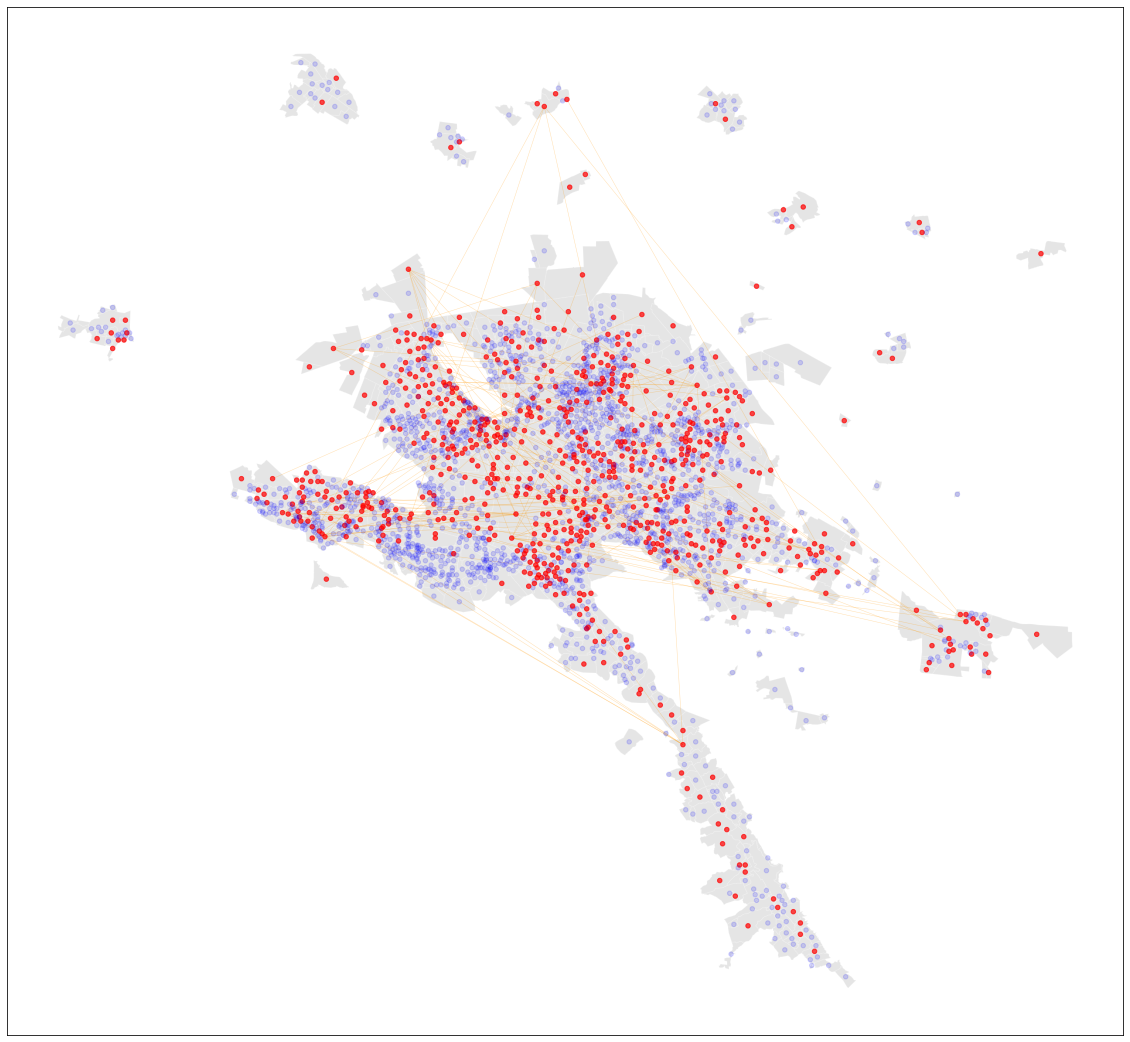

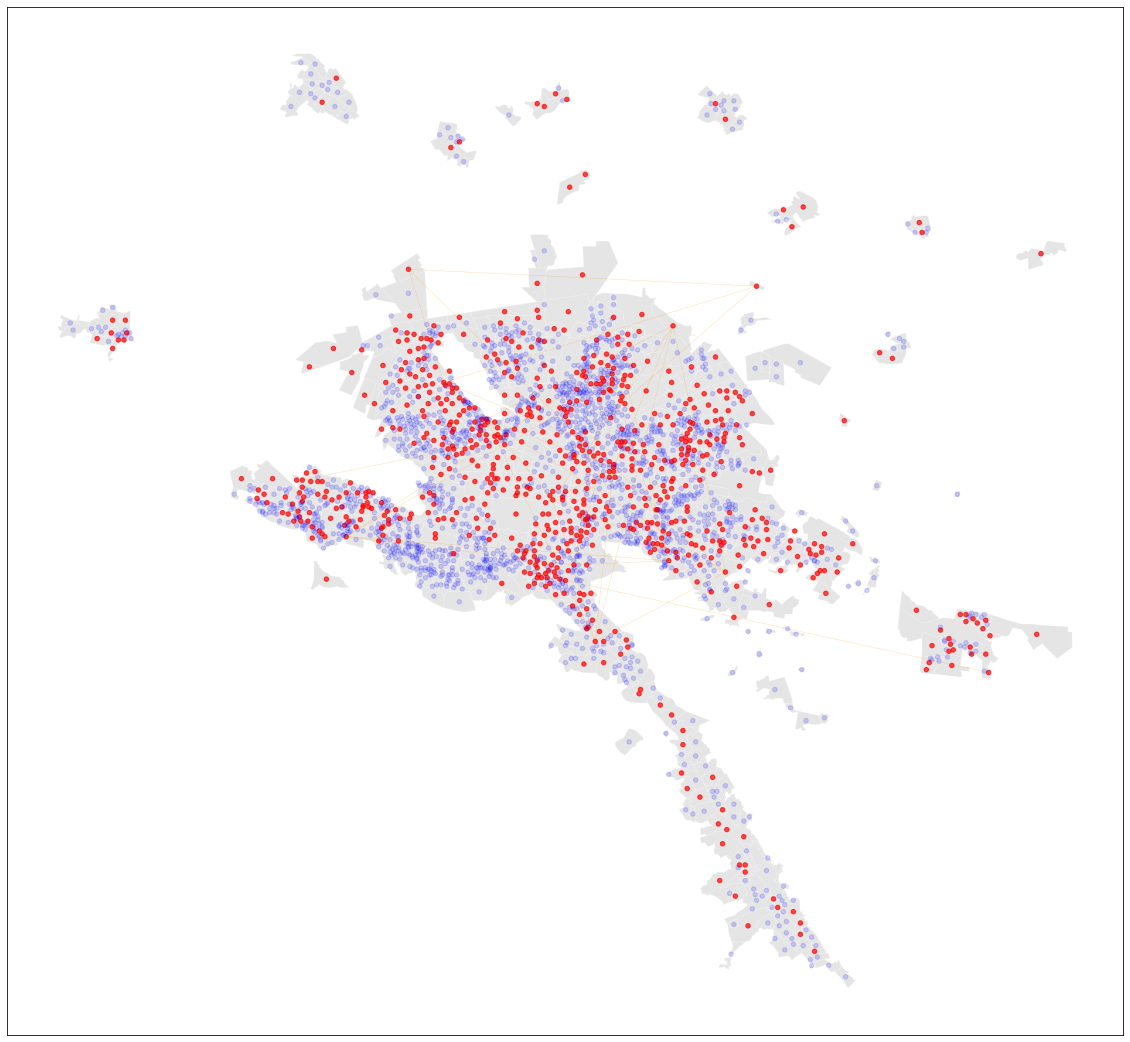

In [70]:
PATH = "../shape"

fp = join(PATH, 'nuevo_leon.shp')

geo_df = gpd.read_file(fp, encoding = 'utf-8')
geo_df = geo_df[geo_df['MUN_NAME'].isin(municipios)]

for net in networks:
    fig, ax = plt.subplots(figsize=(20, 20))
    geo_df.plot(ax=ax, alpha=0.2, edgecolor='white', color = "grey")
    G = nx.from_pandas_edgelist(net, edge_attr ="count")
    G.add_nodes_from(map_df.object_id)
    nx.set_node_attributes(G, nodeData)
    y = nx.get_node_attributes(G, "y_centroid")
    x = nx.get_node_attributes(G, "x_centroid")    
    widths = nx.get_edge_attributes(G, "count").values()
    ewidths = [w if w > 1 else w/2 for w in widths]
    #ewidths = [w if w > 1 else w/2 for w in widths]
    ecolors = [(1.0,0.6, 0.0, 0.5) if w > 1 else (1, 0.6, 0, 0.3) for w in widths]
    pos = {key:[x[key],y[key]] for key in y.keys()}
   
    color = [ (1.0, 0, 0, 0.7) if val else  (0, 0, 1.0, 0.15) for key, val in nx.get_node_attributes(G, "with_event").items()]
    nx.draw_networkx(G, pos = pos, node_color = color, with_labels = False,
                     node_size = 20, width = ewidths, edge_color = ecolors)

    plt.show()

In [71]:
heads = []
year = 2011
i = 0
for net in networks:
    net.columns = ["object_id1", "object_id2", "count"]
    mdf = map_df[["object_id", "mun_name", "neighborhood_name"]]
    mdf.columns = ["object_id1", "mun_name", "neighborhood_name"]
    net = net.sort_values(by="count", ascending = False)
    net = pd.merge(net, mdf, on = ["object_id1"], how = "left")
    mdf.columns = ["object_id2", "mun_name", "neighborhood_name"]
    net = pd.merge(net, mdf, on = ["object_id2"], how = "left")
    net['year'] =  year + i
    i += 1
    heads.append(net)

In [73]:
pd.concat(heads).to_csv("../data/network_weekly_coocurrences.csv", index = False)

### One week difference network

In [ ]:
network = []
for i in range(len(df_agg.index.levels[0])-1):
    in_week1 = df_agg.loc[idx[df_agg.index.levels[0][i], :], :].index.get_level_values(1).tolist()
    in_week2 = df_agg.loc[idx[df_agg.index.levels[0][i+1], :], :].index.get_level_values(1).tolist()
    all_neighborhoods = sorted(in_week1 + in_week2)
    same_week_c =  list(combinations(in_week1, 2)) + list(combinations(in_week2, 2))
    comb = list(combinations(all_neighborhoods, 2))
    for c in same_week_c:
        comb.remove(c)
    if comb:
        network.append(np.insert(np.array(comb), 2,  [df_agg.index.levels[0][i]], axis = 1))

In [ ]:
network_df = pd.DataFrame(np.concatenate(network), columns = ["source", "target", "week_id"])

In [ ]:
network_df["week_date"] = network_df.week_id.apply(lambda x: df_agg.index.levels[2][np.where(df_agg.index.levels[0] == x)[0][0]]) 

In [ ]:
network_df.to_csv("../data/network_one_week_apart_with_dates.csv")

In [ ]:
network_agg = network_df.groupby(["source", "target"]).agg(weight=('week_id', "count")).reset_index()
network_agg.sort_values('weight', ascending=False)

# network_agg.to_csv("../data/network_one_week_apart.csv")